In [4]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
from vtl.Readfile import Readfile
from spec_id import RT_spec,Gen_spec, Analyze_LH_lwa,Median_w_Error_cont,Leave_one_out
import matplotlib.pyplot as plt
from astropy.cosmology import Planck13, z_at_value
from astropy.table import Table
from astropy.io import fits
import astropy
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
import os
import cPickle
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [5]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [10]:
for i in galDB.index:
    P,PZ,Pt = Analyze_LH_lwa('../chidat/%s_dtau_chidata.npy' % galDB['gids'][i],galDB['hi_res_specz'][i],
                          metal,age,tau,age_conv='../data/light_weight_scaling_2.npy')
    np.save('../chidat/%s_dtau_tZ_pos_lwa_2.npy' % galDB['gids'][i],P)
    np.save('../chidat/%s_dtau_Z_pos_lwa_2.npy' % galDB['gids'][i],[metal,PZ])
    np.save('../chidat/%s_dtau_t_pos_lwa_2.npy' % galDB['gids'][i],[age,Pt])

In [3]:
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
mzDB = mzDB.query('ids != 14713 and ids != 38126')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')
gmtlDB = galDB.query('1.45 > hi_res_specz')
gmtlDB = gmtlDB.query('ids != 14713 and ids != 38126')

In [49]:
"""DATA"""

def Bootstrap_errors_lfit(masses,metals,ers,sampling=np.arange(10,11.75,.01),its=1000):
    l_grid = np.zeros([its,len(sampling)])
    IDs = np.arange(len(masses))
    for i in range(its):
        IDn = np.random.choice(IDs,len(IDs),replace=True)
        lvals = np.polyfit(masses[IDn],np.log10(metals[IDn]/.019),1,w = 1/ers[IDn]**2)
        lfit = np.polyval(lvals,sampling)
        l_grid[i] = lfit
        
    m_fit = np.mean(l_grid,axis=0)
    low_ers = np.zeros(len(samp))
    hi_ers = np.zeros(len(samp))
    
    for i in range(len(l_grid.T)):
        low_ers[i] = np.sort(l_grid.T[i])[150]
        hi_ers[i] = np.sort(l_grid.T[i])[830]
    return low_ers,hi_ers, m_fit

Pl_grid,Pm_grid,Ph_grid,Puh_grid = [[],[],[],[]]
for i in lzDB.index:
    x,Px = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % lzDB['gids'][i])
    Pl_grid.append(Px)
 
for i in mzDB.index:
    x,Px = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % mzDB['gids'][i])
    Pm_grid.append(Px)

for i in hzDB.index:
    x,Px = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % hzDB['gids'][i])
    Ph_grid.append(Px)

for i in uhzDB.index:
    x,Px = np.load('../chidat/%s_dtau_Z_pos_lwa.npy' % uhzDB['gids'][i])
    Puh_grid.append(Px)

Pl_grid = np.array(Pl_grid)
Pm_grid = np.array(Pm_grid)
Ph_grid = np.array(Ph_grid)
Puh_grid = np.array(Puh_grid)

W = Leave_one_out(Pl_grid,metal)
top = np.zeros(Pl_grid.shape)
for i in range(W.size):
    top[i] = W[i] * Pl_grid[i]
Pl =sum(top)/sum(W)
Pl /= np.trapz(Pl,metal)

W = Leave_one_out(Pm_grid,metal)
top = np.zeros(Pm_grid.shape)
for i in range(W.size):
    top[i] = W[i] * Pm_grid[i]
Pm =sum(top)/sum(W)
Pm /= np.trapz(Pm,metal)

W = Leave_one_out(Ph_grid,metal)
top = np.zeros(Ph_grid.shape)
for i in range(W.size):
    
    top[i] = W[i] * Ph_grid[i]
Ph =sum(top)/sum(W)
Ph /= np.trapz(Ph,metal)

W = Leave_one_out(Puh_grid,metal)
top = np.zeros(Puh_grid.shape)
for i in range(W.size):
    top[i] = W[i] * Puh_grid[i]
Puh =sum(top)/sum(W)
Puh /= np.trapz(Puh,metal)

lmed,ller,lher=Median_w_Error_cont(Pl,metal)
mmed,mler,mher=Median_w_Error_cont(Pm,metal)
hmed,hler,hher=Median_w_Error_cont(Ph,metal)
uhmed,uhler,uhher=Median_w_Error_cont(Puh,metal)

logm,gmetal=Readfile('../data/Gallazzi_12.dat',0)
cvx,cvy=Readfile('../data/Gallazzi_12_line.dat',0)
cv1x,cv1y=Readfile('../data/gallazzi_points_curve1.dat',0)

lZ=np.array(lzDB['Zx_lwa'])
mZ=np.array(mzDB['Zx_lwa'])
hZ=np.array(hzDB['Zx_lwa'])
uhZ=np.array(uhzDB['Zx_lwa'])
gmtlZ=np.array(gmtlDB['Zx_lwa'])

lerrs = gmtlDB['Zx_-_sig_lwa']/(gmtlDB['Zx_lwa'] * np.log(10))
herrs = gmtlDB['Zx_+_sig_lwa']/(gmtlDB['Zx_lwa'] * np.log(10))
errs = (gmtlDB['Zx_-_sig_lwa'] + gmtlDB['Zx_+_sig_lwa']/2) / (gmtlDB['Zx_lwa'] * np.log(10))
lvals,cov = np.polyfit(gmtlDB['lmass'],np.log10(gmtlZ/.019),1,w = 1/errs**2,cov=True)

lfit = np.polyval(lvals,np.arange(10,11.75,.01))

samp = np.arange(10,11.75,.01)
low_ers,hi_ers,m_fit = Bootstrap_errors_lfit(gmtlDB['lmass'].values,gmtlZ,errs.values,sampling=samp)

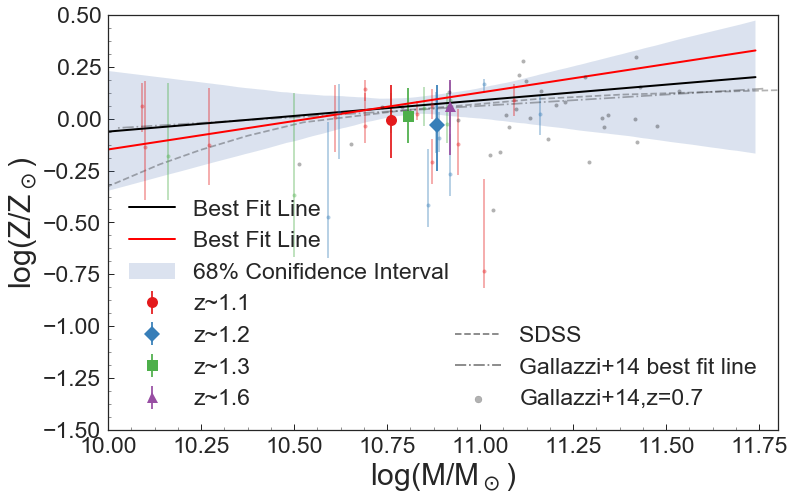

In [5]:
###PLOT
%matplotlib inline

plt.figure(figsize=[12,8])
currentAxis = plt.gca()

####gallazzi points
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.3,markersize=4)
sdss=plt.axhline(y=5,linestyle='--',color='k',alpha=.5)
plt.plot(cvx,cvy,zorder=2,linestyle='-.',color='k',alpha=.3,ms=4)
galbf=plt.axhline(y=5,linestyle='-.',color='k',alpha=.5)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.3,markersize=4)
galpts = plt.scatter(100,100,marker='o',zorder=3,color='k',alpha=.3)#,label='Gallazzi+14,z=0.7')
legend1 = plt.legend([sdss,galbf,galpts],['SDSS','Gallazzi+14 best fit line','Gallazzi+14,z=0.7'],loc = 4,fontsize=23)
currentAxis.add_artist(legend1)
#####single galaxy points

plt.errorbar(lzDB['lmass'],np.log10(lZ/0.019), yerr=[lzDB['Zx_-_sig_dt']/(lzDB['Zx_dt'] * np.log(10)),lzDB['Zx_+_sig_dt']/(lzDB['Zx_dt'] * np.log(10))]
             ,color='#e41a1c',alpha=.4,ms=4,fmt='o')
plt.errorbar(mzDB['lmass'],np.log10(mZ/0.019), yerr=[mzDB['Zx_-_sig_dt']/(mzDB['Zx_dt'] * np.log(10)),mzDB['Zx_+_sig_dt']/(mzDB['Zx_dt'] * np.log(10))]
             ,color='#377eb8',alpha=.4,ms=4,fmt='o')
plt.errorbar(hzDB['lmass'],np.log10(hZ/0.019), yerr=[hzDB['Zx_-_sig_dt']/(hzDB['Zx_dt'] * np.log(10)),hzDB['Zx_+_sig_dt']/(hzDB['Zx_dt'] * np.log(10))]
             ,color='#4daf4a',alpha=.4,ms=4,fmt='o')
plt.plot(samp,m_fit,'k',linewidth=2,label ='Best Fit Line')
plt.plot(samp,lfit,'r',linewidth=2,label ='Best Fit Line')
plt.fill_between(samp,low_ers,hi_ers,alpha = .2,label = '68% Conifidence Interval')

plt.errorbar(np.median(lzDB['lmass']),np.log10(lmed/0.019), yerr=[[ller/(lmed * np.log(10))],[lher/(lmed * np.log(10))]],
             color='#e41a1c',ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['lmass']),np.log10(mmed/0.019),  yerr=[[mler/(mmed * np.log(10))],[mher/(mmed * np.log(10))]],
             color='#377eb8',ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['lmass']),np.log10(hmed/0.019),  yerr=[[hler/(hmed * np.log(10))],[hher/(hmed * np.log(10))]],
             color='#4daf4a',ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['lmass']),np.log10(uhmed/0.019), yerr=[[uhler/(uhmed * np.log(10))],[uhher/(uhmed * np.log(10))]],
             color='#984ea3',ms=11,fmt='^',label='z~1.6')

plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()

plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)
plt.show()
# plt.savefig('../plots/metalmass_featgroup_10-17.pdf',bbox_inches = 'tight')
plt.close()

In [50]:
print lvals
print cov
print cov[0][1]/(cov[0][0]*cov[1][1])

[ 0.27431174 -2.89103887]
[[ 0.01569155 -0.17108761]
 [-0.17108761  1.86565527]]
-5.84414775191


In [69]:
x=gmtlDB['lmass'].values
y=np.log10(gmtlZ/.019)
w=1/errs**2

In [200]:
A =(sum(w*x**2)*sum(w*y)-sum(w*x)*sum(w*x*y))/(sum(w)*sum(w*x**2)-sum(w*x)**2)
sigA =np.sqrt(sum(w*x**2)/(sum(w)*sum(w*x**2)-sum(w*x)**2))
B = (sum(w)*sum(w*x*y)-sum(w*x)*sum(w*y))/(sum(w)*sum(w*x**2)-sum(w*x)**2)
sigB = np.sqrt(sum(w)/(sum(w)*sum(w*x**2)-sum(w*x)**2))
sigAB = (sum(w*x*y)-sum(w*x)*sum(w*y)/sum(w))/sum(w)

In [201]:
print A
print sigA**2
print B
print sigB**2
print sigAB
print sum(x*y*w)/sum(w)-sum(x*w)/sum(w)*sum(y*w)/sum(w)
print np.corrcoef(x,y)

-1.22547892471
2.23709147888
0.116722924597
0.0189691602472
0.00419643046456
0.00419643046456
[[ 1.          0.06234857]
 [ 0.06234857  1.        ]]


In [172]:
eline = np.sqrt(1.87 + samp**2*0.0157 - 2*samp*0.171)
etest = np.sqrt(sigA**2 + (samp*sigB)**2 + 2*samp*.00075)

In [173]:
etest

array([ 2.03691127,  2.03784647,  2.03878217,  2.03971838,  2.04065509,
        2.04159229,  2.04253   ,  2.0434682 ,  2.0444069 ,  2.04534609,
        2.04628579,  2.04722597,  2.04816665,  2.04910783,  2.0500495 ,
        2.05099166,  2.05193431,  2.05287746,  2.05382109,  2.05476522,
        2.05570983,  2.05665493,  2.05760052,  2.0585466 ,  2.05949316,
        2.06044021,  2.06138775,  2.06233577,  2.06328427,  2.06423326,
        2.06518273,  2.06613268,  2.06708311,  2.06803402,  2.06898541,
        2.06993728,  2.07088963,  2.07184246,  2.07279576,  2.07374954,
        2.0747038 ,  2.07565853,  2.07661374,  2.07756942,  2.07852557,
        2.0794822 ,  2.08043929,  2.08139686,  2.0823549 ,  2.08331341,
        2.08427239,  2.08523184,  2.08619175,  2.08715214,  2.08811299,
        2.0890743 ,  2.09003608,  2.09099833,  2.09196104,  2.09292421,
        2.09388785,  2.09485195,  2.09581651,  2.09678153,  2.09774701,
        2.09871295,  2.09967935,  2.10064621,  2.10161353,  2.10

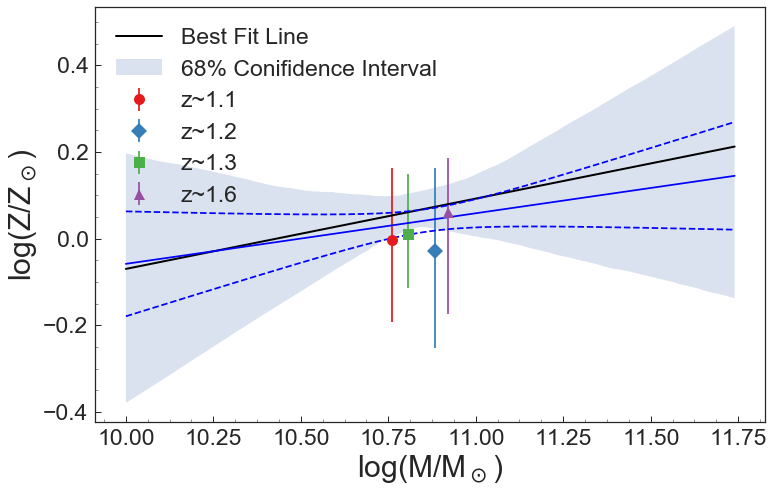

In [222]:
###PLOT
%matplotlib inline

plt.figure(figsize=[12,8])

plt.errorbar(np.median(lzDB['lmass']),np.log10(lmed/0.019), yerr=[[ller/(lmed * np.log(10))],[lher/(lmed * np.log(10))]],
             color='#e41a1c',ms=11,fmt='o',label='z~1.1')
plt.errorbar(np.median(mzDB['lmass']),np.log10(mmed/0.019),  yerr=[[mler/(mmed * np.log(10))],[mher/(mmed * np.log(10))]],
             color='#377eb8',ms=11,fmt='D',label='z~1.2')
plt.errorbar(np.median(hzDB['lmass']),np.log10(hmed/0.019),  yerr=[[hler/(hmed * np.log(10))],[hher/(hmed * np.log(10))]],
             color='#4daf4a',ms=11,fmt='s',label='z~1.3')
plt.errorbar(np.median(uhzDB['lmass']),np.log10(uhmed/0.019), yerr=[[uhler/(uhmed * np.log(10))],[uhher/(uhmed * np.log(10))]],
             color='#984ea3',ms=11,fmt='^',label='z~1.6')

plt.plot(samp,m_fit,'k',linewidth=2,label ='Best Fit Line')

plt.plot(samp,lfit,'b')
plt.plot(samp,lfit - lfit_errs,'b--')
plt.plot(samp,lfit + lfit_errs,'b--')
plt.fill_between(samp,low_ers,hi_ers,alpha = .2,label = '68% Conifidence Interval')


plt.xlabel('log(M/M$_\odot$)',size=30)
plt.ylabel('log(Z/Z$_\odot$)',size=30)
# plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=23)
plt.minorticks_on()

plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=23)
plt.show()
# plt.savefig('../plots/metalmass_featgroup_10-17.pdf',bbox_inches = 'tight')
plt.close()

In [202]:
Y=y
A=np.array([np.ones(len(x)),x]).T
C =np.diag(errs**2)
invC=inv(C)

In [203]:
np.dot(inv(np.dot(np.dot(A.T,invC),A)),np.dot(np.dot(A.T,invC),Y))

array([-1.22547892,  0.11672292])

In [204]:
inv(np.dot(np.dot(A.T,invC),A))

array([[ 2.23709148, -0.20596798],
       [-0.20596798,  0.01896916]])

In [205]:
etest = np.sqrt(sigA**2 + (samp*sigB)**2 - 2*samp*.206)

/Users/vestrada/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [206]:
etest

array([ 0.1183533 ,  0.11697535,  0.11559738,  0.1142194 ,  0.1128414 ,
        0.11146339,  0.11008535,  0.1087073 ,  0.10732923,  0.10595113,
        0.10457302,  0.10319488,  0.10181672,  0.10043853,  0.09906032,
        0.09768209,  0.09630383,  0.09492553,  0.09354721,  0.09216886,
        0.09079048,  0.08941206,  0.08803361,  0.08665512,  0.08527659,
        0.08389802,  0.0825194 ,  0.08114075,  0.07976204,  0.07838329,
        0.07700448,  0.07562561,  0.07424669,  0.07286771,  0.07148866,
        0.07010954,  0.06873035,  0.06735108,  0.06597172,  0.06459228,
        0.06321275,  0.06183311,  0.06045337,  0.05907351,  0.05769353,
        0.05631342,  0.05493316,  0.05355275,  0.05217218,  0.05079143,
        0.04941049,  0.04802933,  0.04664795,  0.04526632,  0.04388441,
        0.0425022 ,  0.04111967,  0.03973677,  0.03835346,  0.03696971,
        0.03558545,  0.03420063,  0.03281518,  0.03142901,  0.03004202,
        0.02865409,  0.02726509,  0.02587483,  0.02448311,  0.02

In [220]:
def Linear_fit(x,Y,sig,new_x):
    A=np.array([np.ones(len(x)),x]).T
    C =np.diag(sig**2)
    iC=inv(C)
    b,m = np.dot(inv(np.dot(np.dot(A.T,iC),A)),np.dot(np.dot(A.T,iC),Y))
    cov = inv(np.dot(np.dot(A.T,invC),A))
    var_b = cov[0][0]
    var_m = cov[1][1]
    sig_mb = cov[0][1]
    sig_y = np.sqrt(var_b + new_x**2*var_m + 2*new_x*sig_mb)
    return m*new_x+b , sig_y

In [221]:
lfit,lfit_errs = Linear_fit(x,y,errs,samp)